# Unstructured Data Analytics
## Project - Tech Strategy Analysis using Earnings Call Reports

Submitted by

| Name   | UT EID |
| ------ | ---   |
| Mihir Deshpande | md46487 |
| Samarth Mishra | sm79247 |
| Muskan Agarwal | ma64547 |
| Sreekar Lanka | sl54387 |
| Rishabh Tiwari | rt27739 |

In [68]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

import re



# Reading the data from text files

In [ ]:
# READ APPLE DATA
apple = pd.DataFrame(columns=['Transcript','FileName'])
import os
for path, currentDirectory, files in os.walk("C:\Users\Mihir\Documents\Fall_Term\UNSTRUCTURED_PROJECT\data"):
    for file in files:
        if file.startswith("AAPL"):
            f = open("C:\Users\Mihir\Documents\Fall_Term\UNSTRUCTURED_PROJECT\data"+str(file), "r")
            apple.loc[len(apple.index),'Transcript'] = f.read()
            apple.loc[len(apple.index)-1,'FileName']=file
            
# READ GOOGLE DATA
google = pd.DataFrame(columns=['Transcript','FileName'])
import os
for path, currentDirectory, files in os.walk("C:\Users\Mihir\Documents\Fall_Term\UNSTRUCTURED_PROJECT\data\GOOGLE"):
    for file in files:
        if file.startswith("GOOG"):
            f = open("C:\Users\Mihir\Documents\Fall_Term\UNSTRUCTURED_PROJECT\data\GOOGLE"+str(file), "r", encoding= 'unicode_escape')
            google.loc[len(google.index)] = f.read()
            google.loc[len(google.index)-1,'FileName']=file

In [ ]:
def remove_txt(x):
    return x.rstrip('.txt')
apple['FileName']=apple['FileName'].map(remove_txt)
apple['Quarter']=apple['FileName'].map(lambda x: x.split("_")[1])
apple['Year']=apple['FileName'].map(lambda x: x.split("_")[2])

In [ ]:
google['FileName']=google['FileName'].map(remove_txt)
google['Quarter']=google['FileName'].map(lambda x: x.split("_")[1])
google['Year']=google['FileName'].map(lambda x: x.split("_")[2])

In [ ]:
apple.to_csv("Apple_data.csv")

google.to_csv("Google_data.csv")

In [16]:

apple_data = pd.read_csv("data/Apple_data.csv")

# Pre Processing -

In [610]:
# For NLP -
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy



def preprocess_data(apple_data, nlp, threshold=-1):
    all_stopwords = stopwords.words('english')
    
    # Add additional stopwords
    
    additional_stop_words = ['hi', 'earning', 'conference', 'speaker', 'analyst', 'operator', 'welcome', \
                         'think', 'cost', 'result', 'primarily', 'overall', 'line', 'general', \
                          'thank', 'see', 'alphabet', 'google', 'facebook', 'amazon', 'microsoft',\
                        'business', 'customer', 'revenue', 'question', 'lady', 'gentleman', \
                        'continue', 'continuing', 'continued', 'focus', 'participant', 'see', 'seeing', \
                        'user', 'work', 'lot', 'day',  'like', 'looking', 'look', 'come', 'yes', 'include', \
                        'investor', 'director', 'expense', 'manager', 'founder', 'chairman', \
                         'chief', 'operating', 'officer', 'executive', 'financial', 'senior', 'vice', 'president', \
                        'opportunity', 'go', 'expect', 'increase', 'quarter', 'stand', 'instructions', \
                        'obviously', 'thing', 'important', 'help', 'bring', 'mention', 'yeah', 'get', 'proceed', \
                        'currency', 'example', 'believe','sundar','pichai','philipp', 'year']
    
    all_stopwords.extend(additional_stop_words)

    wnl = WordNetLemmatizer()
    apple_data['preprocessed'] = apple_data['Transcript']

    temp=[]
    temp_each_sent = []
    name_list=[]
    
    
    for i in range(len(apple_data['Transcript'])):
        print("Iteration ",i,"/",len(apple_data['Transcript']))
        lines_text = []
        temp_list = apple_data['Transcript'][i].split("\n")
        
   
          
        for line in temp_list:
            line_temp = line.lstrip().rstrip()
            
            document = nlp(line_temp)
            name = []
            
            for item in document.ents:
                if item.label_ in ['PERSON']:
                    name.append(item.text)
            name_list.append(name)
            for word in name:
                if word in line_temp:
                    line_temp = line_temp.replace(word, "")
            
            
            lines_text.append(line_temp)
            
        val_count = pd.Series(lines_text).value_counts(ascending=False)   
        unique_doc = list(val_count[val_count.values == 1].index)
        corpus_upd = []
        for i in range(0, len(unique_doc)):
            desc = re.sub('[^a-zA-Z]', ' ', unique_doc[i])
            desc = desc.lower()
            desc = desc.split()
        
            desc = [wnl.lemmatize(word) for word in desc if not word in set(all_stopwords)]
            desc = " ".join(desc)
            corpus_upd.append(desc)
        flatrev = ""
        for elem in corpus_upd:
            flatrev = flatrev+" "+elem

        temp.append(flatrev)
        temp_each_sent.append(corpus_upd)
    
    
    # Remove words above threshold count
    if threshold>0:
        all_words = []
        for i in range(len(temp)):
            desc = temp[i]
            all_words.extend(desc)
        #print(all_words)
        freq_thresh = pd.Series(all_words).value_counts(ascending=False)
        less_thresh = list(freq_thresh[freq_thresh.values > threshold].index)
        for i in range(len(temp)):
            for word in less_thresh:
                #print(word)
                temp[i] = temp[i].replace(" "+word+" "," ")
            
    
    
    
    
    return temp, temp_each_sent, name_list
    
    

# LDA Function

In [785]:
def show_lda_topic (document_matrix,num_components=5):
    # Initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # Vectorize document using TF-IDF
    tfidf = TfidfVectorizer(lowercase=True,
                            stop_words='english',
                            ngram_range = (3,3),
                            tokenizer = tokenizer.tokenize)

    # Fit and Transform the documents
    train_data = tfidf.fit_transform(list(document_matrix)) 
    # Define the number of topics or components
    

    # Create LDA object
    model=LatentDirichletAllocation(n_components=num_components)

    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(train_data)

    # Get Components 
    lda_components=model.components_
    # Print the topics with their terms
    terms = tfidf.get_feature_names()

    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:20]
        top_terms_list=list(dict(top_terms_key).keys())
        top_value_list=list(dict(top_terms_key).values())
        print("Topic "+str(index)+": ",top_terms_list,"\n")
        #print("Value "+str(index)+": ",top_value_list,"\n\n")
        
    return model.transform(train_data)

# GOOGLE DATA ANALYSIS

In [826]:
# Let's check for google data
google_data = pd.read_csv("data/GOOGLE_DATA_PREPROC.csv")

#google_data = google_data.drop(["Unnamed: 0.1", "Unnamed: 0","FileName"],axis=1)

In [829]:
nlp = spacy.load('en_core_web_md')

temp, temp_each_sent, name_list = preprocess_data(google_data,nlp,1500)
google_data['preprocessed'] = temp
google_data['preprocessed_sent'] = temp_each_sent

Iteration  0 / 61
Iteration  1 / 61
Iteration  2 / 61
Iteration  3 / 61
Iteration  4 / 61
Iteration  5 / 61
Iteration  6 / 61
Iteration  7 / 61
Iteration  8 / 61
Iteration  9 / 61
Iteration  10 / 61
Iteration  11 / 61
Iteration  12 / 61
Iteration  13 / 61
Iteration  14 / 61
Iteration  15 / 61
Iteration  16 / 61
Iteration  17 / 61
Iteration  18 / 61
Iteration  19 / 61
Iteration  20 / 61
Iteration  21 / 61
Iteration  22 / 61
Iteration  23 / 61
Iteration  24 / 61
Iteration  25 / 61
Iteration  26 / 61
Iteration  27 / 61
Iteration  28 / 61
Iteration  29 / 61
Iteration  30 / 61
Iteration  31 / 61
Iteration  32 / 61
Iteration  33 / 61
Iteration  34 / 61
Iteration  35 / 61
Iteration  36 / 61
Iteration  37 / 61
Iteration  38 / 61
Iteration  39 / 61
Iteration  40 / 61
Iteration  41 / 61
Iteration  42 / 61
Iteration  43 / 61
Iteration  44 / 61
Iteration  45 / 61
Iteration  46 / 61
Iteration  47 / 61
Iteration  48 / 61
Iteration  49 / 61
Iteration  50 / 61
Iteration  51 / 61
Iteration  52 / 61
Ite

In [789]:
# Get Post-Pichai Data

google_post_pichai = google_data[google_data['Year']>14]

# Let's first get quarters
qoq_transcript = google_post_pichai.groupby(by = 'Quarter').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(qoq_transcript['preprocessed'],3)
#count = 0
#for i in qoq_transcript['preprocessed']:
 #   if 'Philip' in i:
  #      count = count+1
#count

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['stock based compensation', 'free cash flow', 'earnings press release', 'long term growth', 'talk little bit', 'cash flow billion', 'effective tax rate', 'non gaap measure', 'gaap non gaap', 'traffic acquisition cost', 'statement involve number', 'involve number risk', 'number risk uncertainty', 'cause actual result', 'statement make today', 'safe harbor statement', 'risk uncertainty cause', 'uncertainty cause actual', 'non gaap basis', 'cover safe harbor'] 

Topic 1:  ['stock based compensation', 'free cash flow', 'earnings press release', 'effective tax rate', 'long term growth', 'talk little bit', 'cash flow billion', 'non gaap measure', 'traffic acquisition cost', 'involve number risk', 'statement involve number', 'cause actual result', 'number risk uncertainty', 'actual result differ', 'statement make today', 'risk uncertainty cause', 'uncertainty cause actual', 'cover safe harbor', 'quickly cover safe', 'result differ materially'] 

Topic 2:  ['stock based compensation

array([[0.99481868, 0.00259423, 0.00258709],
       [0.00256342, 0.00256927, 0.99486731],
       [0.99440691, 0.00279909, 0.002794  ],
       [0.99393639, 0.00303376, 0.00302985]])

In [800]:
## Let's now get years
yoy_transcript = google_post_pichai.groupby(by = 'Year').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(yoy_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['fixed fx term', 'stock based compensation', 'billion versus margin', 'cash flow billion', 'earlier month launched', 'carry higher tac', 'site tac percentage', 'tac percentage site', 'afternoon earnings today', 'mobile search programmatic', 'cloud play hardware', 'tac mobile search', 'estimated total conversion', 'earnings press release', 'long term growth', 'afternoon thanks taking', 'gentleman earnings time', 'machine learning make', 'make mobile web', 'mobile web better'] 

Topic 1:  ['stock based compensation', 'free cash flow', 'effective tax rate', 'benefit hedging program', 'paid click growth', 'product listing ad', 'non gaap margin', 'resulting non gaap', 'consumer online activity', 'billion resulting non', 'cash provided activity', 'forward statement reflect', 'earnings press release', 'talk little bit', 'expressed non gaap', 'adjusted exclude charge', 'description risk factor', 'factor affect result', 'net cash provided', 'note certain measure'] 

Topic 2:  ['earni

array([[0.00406622, 0.00406385, 0.99186993],
       [0.00353961, 0.9929375 , 0.00352289],
       [0.99260572, 0.00368644, 0.00370783],
       [0.00381494, 0.00379383, 0.99239123],
       [0.00366276, 0.99267963, 0.00365761],
       [0.0035126 , 0.99299107, 0.00349632],
       [0.00378403, 0.00375546, 0.99246051],
       [0.0049658 , 0.99006032, 0.00497387]])

In [791]:
# Get Pre-Pichai Data

google_pre_pichai = google_data[google_data['Year']<=14]

# Let's first get quarters
qoq_transcript = google_pre_pichai.groupby(by = 'Quarter').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(qoq_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['schindler svp cbo', 'earnings press release', 'stock based compensation', 'cash flow billion', 'free cash flow', 'broad based strength', 'activity broad based', 'based strength advertiser', 'strength advertiser spend', 'long term growth', 'thanks taking question', 'revenue billion driven', 'involve number risk', 'number risk uncertainty', 'statement involve number', 'result differ materially', 'advertising revenue billion', 'business digital content', 'elevated consumer online', 'online activity broad'] 

Topic 1:  ['stock based compensation', 'earnings press release', 'free cash flow', 'cash flow billion', 'long term growth', 'talk little bit', 'thanks taking question', 'non gaap measure', 'involve number risk', 'number risk uncertainty', 'statement involve number', 'result differ materially', 'actual result differ', 'cause actual result', 'risk uncertainty cause', 'uncertainty cause actual', 'statement make today', 'traffic acquisition cost', 'paid click growth', 'relatio

array([[0.00256026, 0.00256541, 0.99487433],
       [0.0026493 , 0.00263635, 0.99471435],
       [0.99466514, 0.00266356, 0.0026713 ],
       [0.00254288, 0.00254861, 0.9949085 ]])

In [794]:
# Let's now get years
yoy_transcript = google_pre_pichai.groupby(by = 'Year').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(yoy_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['paid click growth', 'stock based compensation', 'global sale operation', 'aggregate paid click', 'click growth rate', 'talk little bit', 'non gaap profit', 'free cash flow', 'benefit hedging program', 'management global sale', 'product management global', 'non gaap margin', 'let quickly cover', 'detailed description risk', 'activity remove capital', 'description risk factor', 'refer free cash', 'remove capital expenditure', 'resulting non gaap', 'million stock based'] 

Topic 1:  ['earnings press release', 'stock based compensation', 'fixed fx term', 'thanks taking question', 'billion versus margin', 'cash flow billion', 'long term growth', 'benefit hedging program', 'site tac percentage', 'income billion versus', 'billion excluding stock', 'total advertising revenue', 'excluding stock based', 'earnings diluted share', 'net income billion', 'free cash flow', 'content acquisition cost', 'open thanks taking', 'machine learning ai', 'non gaap measure'] 

Topic 2:  ['stock base

array([[0.00660045, 0.00657514, 0.98682441],
       [0.99285057, 0.00356559, 0.00358384],
       [0.00351005, 0.99299804, 0.00349191],
       [0.00371395, 0.99256404, 0.00372201],
       [0.00504282, 0.98989097, 0.00506621],
       [0.00360734, 0.00358846, 0.9928042 ],
       [0.99243766, 0.00378475, 0.00377759],
       [0.00404009, 0.99193497, 0.00402494],
       [0.00424834, 0.99145316, 0.0042985 ],
       [0.00376468, 0.00382403, 0.99241129]])

# APPLE DATA ANALYSIS

In [632]:
apple_data.to_csv("data/APPLE_PREPROCESSED.csv")
nlp = spacy.load('en_core_web_md')

temp, temp_each_sent, name_list_apple = preprocess_data(apple_data,nlp,1000)

apple_data['preprocessed'] = temp
apple_data['preprocessed_sent'] = temp_each_sent

Iteration  0 / 67
Iteration  1 / 67
Iteration  2 / 67
Iteration  3 / 67
Iteration  4 / 67
Iteration  5 / 67
Iteration  6 / 67
Iteration  7 / 67
Iteration  8 / 67
Iteration  9 / 67
Iteration  10 / 67
Iteration  11 / 67
Iteration  12 / 67
Iteration  13 / 67
Iteration  14 / 67
Iteration  15 / 67
Iteration  16 / 67
Iteration  17 / 67
Iteration  18 / 67
Iteration  19 / 67
Iteration  20 / 67
Iteration  21 / 67
Iteration  22 / 67
Iteration  23 / 67
Iteration  24 / 67
Iteration  25 / 67
Iteration  26 / 67
Iteration  27 / 67
Iteration  28 / 67
Iteration  29 / 67
Iteration  30 / 67
Iteration  31 / 67
Iteration  32 / 67
Iteration  33 / 67
Iteration  34 / 67
Iteration  35 / 67
Iteration  36 / 67
Iteration  37 / 67
Iteration  38 / 67
Iteration  39 / 67
Iteration  40 / 67
Iteration  41 / 67
Iteration  42 / 67
Iteration  43 / 67
Iteration  44 / 67
Iteration  45 / 67
Iteration  46 / 67
Iteration  47 / 67
Iteration  48 / 67
Iteration  49 / 67
Iteration  50 / 67
Iteration  51 / 67
Iteration  52 / 67
Ite

In [795]:
# Get Post-Cook Data

apple_post_cook = apple_data[apple_data['Year']>11]

# Let's first get quarters
qoq_transcript = apple_post_cook.groupby(by = 'Quarter').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(qoq_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['new september record', 'strong double digit', 'payable november shareholder', 'new time record', 'ahead december review', 'december review outlook', 'fourth fiscal earnings', 'november shareholder record', 'double digit growth', 'good afternoon thanks', 'september record billion', 'shareholder record november', 'launch new product', 'afternoon thanks joining', 'apple incorporated fourth', 'incorporated fourth fiscal', 'stock payable november', 'new time high', 'set time record', 'reached new time'] 

Topic 1:  ['new june record', 'strong double digit', 'new march record', 'double digit growth', 'set june record', 'june record billion', 'active installed base', 'capital return program', 'new time high', 'good afternoon thanks', 'margin basis point', 'gross margin basis', 'basis point sequentially', 'wearable home accessory', 'afternoon thanks joining', 'channel inventory reduction', 'reached new time', 'new time record', 'set new june', 'talk little bit'] 

Topic 2:  ['new t

array([[0.00258024, 0.00259652, 0.99482324],
       [0.00261097, 0.99477452, 0.00261451],
       [0.00262393, 0.9947504 , 0.00262567],
       [0.99472925, 0.00264269, 0.00262807]])

In [809]:
# Let's now get years
yoy_transcript = apple_post_cook.groupby(by = 'Year').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(yoy_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['week target range', 'channel inventory reduction', 'itunes software service', 'capital return program', 'iphone iphone plus', 'strong double digit', 'seven week target', 'end guidance range', 'high end guidance', 'number paying account', 'talk little bit', 'sold million iphones', 'satisfaction rate ipad', 'time quarterly record', 'outside united state', 'tied installed base', 'income tax future', 'marketable security sequential', 'channel inventory million', 'inventory million unit'] 

Topic 1:  ['stock based compensation', 'talk little bit', 'target range week', 'billion compared billion', 'double digit growth', 'compared million ago', 'compared billion ago', 'supply demand balance', 'iphone channel inventory', 'growth geographic segment', 'cash flow operation', 'new product pipeline', 'afternoon thanks joining', 'capital return program', 'active installed base', 'time quarterly record', 'new time record', 'good afternoon thanks', 'related stock based', 'million related st

array([[0.00414669, 0.99170307, 0.00415024],
       [0.00395655, 0.00396213, 0.99208132],
       [0.99212549, 0.00394091, 0.0039336 ],
       [0.00391653, 0.99219141, 0.00389207],
       [0.99212118, 0.0039443 , 0.00393451],
       [0.99185333, 0.00407481, 0.00407186],
       [0.00398318, 0.99201457, 0.00400224],
       [0.00397484, 0.00397946, 0.99204569],
       [0.00403054, 0.00403117, 0.99193829],
       [0.00402869, 0.00402923, 0.99194208],
       [0.00470713, 0.00470835, 0.99058453]])

In [797]:
# Get Pre-Cook Data

apple_pre_cook = apple_data[apple_data['Year']<=11]

# Let's first get quarters
qoq_transcript = apple_pre_cook.groupby(by = 'Quarter').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(qoq_transcript['preprocessed'],3)

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['stock based compensation', 'related stock based', 'million related stock', 'compared million ago', 'talk little bit', 'iphone apple tv', 'new accounting principle', 'target range week', 'million tax rate', 'non gaap measure', 'apple retail store', 'including million related', 'million compared million', 'good afternoon thanks', 'based latest data', 'cash flow operation', 'net income billion', 'supply demand balance', 'actual result trend', 'includes type forward'] 

Topic 1:  ['stock based compensation', 'related stock based', 'million related stock', 'talk little bit', 'compared million ago', 'target range week', 'supply demand balance', 'million tax rate', 'million compared million', 'including million related', 'apple retail store', 'good afternoon thanks', 'non gaap measure', 'iphone apple tv', 'education buying season', 'ipod channel inventory', 'gross margin expense', 'actual result trend', 'includes type forward', 'information refer risk'] 

Topic 2:  ['stock based c

array([[0.99324307, 0.0033756 , 0.00338133],
       [0.00344527, 0.00341747, 0.99313725],
       [0.99311086, 0.00343915, 0.00344999],
       [0.99331787, 0.00333966, 0.00334248]])

In [808]:
# Let's now get years
yoy_transcript = apple_pre_cook.groupby(by = 'Year').aggregate({'preprocessed':lambda x : " ".join(x)})

# Lets see if LDA returns anything

show_lda_topic(yoy_transcript['preprocessed'],3)

Topic 0:  ['stock based compensation', 'iphone apple tv', 'cash stock based', 'representing growth ago', 'related stock based', 'non cash stock', 'million related stock', 'million including million', 'favorable commodity environment', 'commodity pricing environment', 'customer store week', 'earnings share talk', 'environment product mix', 'favorable commodity pricing', 'generate eps including', 'gross margin corporate', 'ipod representing growth', 'new software feature', 'representing customer store', 'store representing customer'] 

Topic 1:  ['stock based compensation', 'intel based mac', 'talk little bit', 'related stock based', 'million related stock', 'based compensation non', 'compensation non gaap', 'itunes music store', 'gaap gross margin', 'compared million ago', 'non gaap measure', 'gross margin gaap', 'target range week', 'supply demand balance', 'cash stock based', 'non cash stock', 'million tax rate', 'billion compared billion', 'good afternoon thanks', 'including million 

C:\Users\Mihir\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.00448382, 0.99104999, 0.00446618],
       [0.99159913, 0.0042096 , 0.00419128],
       [0.00404652, 0.99189603, 0.00405745],
       [0.00415733, 0.00417576, 0.99166691],
       [0.00407158, 0.00408854, 0.99183988],
       [0.00409458, 0.99178093, 0.00412449]])

# Sentiment Analysis

In [695]:
def get_sentiment(dataframe,dataframe_sentiment):
    count = 0
    pos=[]
    neg=[]
    unc=[]
    con=[]
    for elem in dataframe['preprocessed']:
        count=count+1
        print("Iteration - ",count,"/",len(dataframe['preprocessed']))
        count_pos = 0
        count_neg = 0
        count_unc = 0
        count_con = 0
    
        list_split = elem.split()
        for word in list_split:
            mask = dataframe_sentiment['word']==word
            temp = dataframe_sentiment[mask]['sentiment']
            if "Positive" in list(temp):
                count_pos=count_pos+1
            elif "Negative" in list(temp):
                count_neg=count_neg+1
            elif "Uncertainty" in list(temp):
                count_unc=count_unc+1
            elif "Constraining" in list(temp):
                count_con=count_con+1
        pos.append(count_pos)
        neg.append(count_neg)
        unc.append(count_unc)
        con.append(count_con)
        
    return pos, neg, unc, con

In [784]:
# Get sentiments

# LM-McDonald Scale
dataframe_sentiment = pd.read_csv("data/LM-SA-2020.csv")



## Google

In [830]:
pos, neg, unc, con = get_sentiment(google_data,dataframe_sentiment)

Iteration -  1 / 61
Iteration -  2 / 61
Iteration -  3 / 61
Iteration -  4 / 61
Iteration -  5 / 61
Iteration -  6 / 61
Iteration -  7 / 61
Iteration -  8 / 61
Iteration -  9 / 61
Iteration -  10 / 61
Iteration -  11 / 61
Iteration -  12 / 61
Iteration -  13 / 61
Iteration -  14 / 61
Iteration -  15 / 61
Iteration -  16 / 61
Iteration -  17 / 61
Iteration -  18 / 61
Iteration -  19 / 61
Iteration -  20 / 61
Iteration -  21 / 61
Iteration -  22 / 61
Iteration -  23 / 61
Iteration -  24 / 61
Iteration -  25 / 61
Iteration -  26 / 61
Iteration -  27 / 61
Iteration -  28 / 61
Iteration -  29 / 61
Iteration -  30 / 61
Iteration -  31 / 61
Iteration -  32 / 61
Iteration -  33 / 61
Iteration -  34 / 61
Iteration -  35 / 61
Iteration -  36 / 61
Iteration -  37 / 61
Iteration -  38 / 61
Iteration -  39 / 61
Iteration -  40 / 61
Iteration -  41 / 61
Iteration -  42 / 61
Iteration -  43 / 61
Iteration -  44 / 61
Iteration -  45 / 61
Iteration -  46 / 61
Iteration -  47 / 61
Iteration -  48 / 61
I

In [831]:
google_data['pos_LMD_sent_freq'] = pos
google_data['neg_LMD_sent_freq'] = neg
google_data['unc_LMD_sent_freq'] = unc
google_data['con_LMD_sent_freq'] = con

In [832]:
# google_data.plot(x=[] ,y=[])
google_data.sort_values(by = ['Year','Quarter'],axis =0,ascending =[True, True], inplace = True)

In [833]:
google_data['year_quarter'] = google_data['Year'].apply(str)+"-"+google_data['Quarter']
google_data_agg = google_data.groupby(by = 'Year').mean()

In [834]:
google_data_agg['Year'] = pd.Series(google_data_agg.index).apply(str)

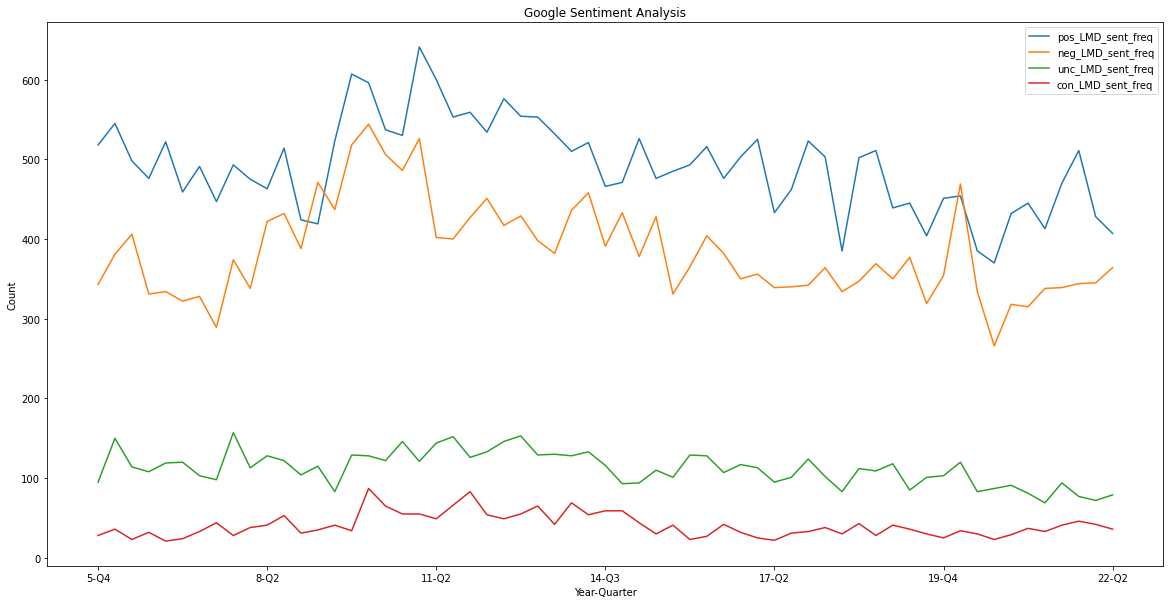

In [835]:
ax = google_data.plot(x ='year_quarter',y=['pos_LMD_sent_freq','neg_LMD_sent_freq','unc_LMD_sent_freq','con_LMD_sent_freq'],kind='line',
                figsize=(20,10),title="Google Sentiment Analysis",xlabel="Year-Quarter",ylabel="Count")
#ax.set_facecolor('black')
plt.savefig("output_googl.png") #save as png

## Apple


In [758]:
pos_a, neg_a, unc_a, con_a = get_sentiment(apple_data,dataframe_sentiment)

Iteration -  1 / 67
Iteration -  2 / 67
Iteration -  3 / 67
Iteration -  4 / 67
Iteration -  5 / 67
Iteration -  6 / 67
Iteration -  7 / 67
Iteration -  8 / 67
Iteration -  9 / 67
Iteration -  10 / 67
Iteration -  11 / 67
Iteration -  12 / 67
Iteration -  13 / 67
Iteration -  14 / 67
Iteration -  15 / 67
Iteration -  16 / 67
Iteration -  17 / 67
Iteration -  18 / 67
Iteration -  19 / 67
Iteration -  20 / 67
Iteration -  21 / 67
Iteration -  22 / 67
Iteration -  23 / 67
Iteration -  24 / 67
Iteration -  25 / 67
Iteration -  26 / 67
Iteration -  27 / 67
Iteration -  28 / 67
Iteration -  29 / 67
Iteration -  30 / 67
Iteration -  31 / 67
Iteration -  32 / 67
Iteration -  33 / 67
Iteration -  34 / 67
Iteration -  35 / 67
Iteration -  36 / 67
Iteration -  37 / 67
Iteration -  38 / 67
Iteration -  39 / 67
Iteration -  40 / 67
Iteration -  41 / 67
Iteration -  42 / 67
Iteration -  43 / 67
Iteration -  44 / 67
Iteration -  45 / 67
Iteration -  46 / 67
Iteration -  47 / 67
Iteration -  48 / 67
I

In [759]:
apple_data['pos_LMD_sent_freq'] = pos_a
apple_data['neg_LMD_sent_freq'] = neg_a
apple_data['unc_LMD_sent_freq'] = unc_a
apple_data['con_LMD_sent_freq'] = con_a

In [776]:
# google_data.plot(x=[] ,y=[])
apple_data.sort_values(by = ['Year','Quarter'],axis =0,ascending =[True, True], inplace = True)

In [815]:
apple_data['year_quarter'] = apple_data['Year'].apply(str)+"-"+apple_data['Quarter']

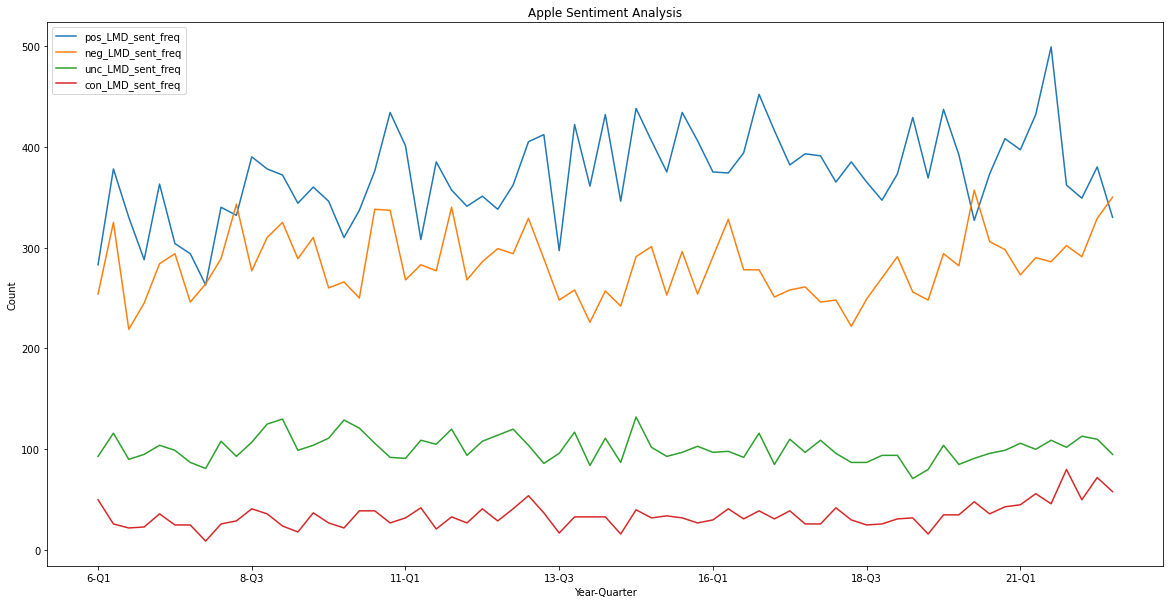

In [783]:
apple_data.plot(x ='year_quarter',y=['pos_LMD_sent_freq','neg_LMD_sent_freq','unc_LMD_sent_freq','con_LMD_sent_freq'],kind='line',
               figsize=(20,10),title="Apple Sentiment Analysis",xlabel="Year-Quarter",ylabel="Count")
plt.savefig("output_apl.png") #save as png

## Lets use Vader -

In [817]:
def cal_neg_sent_scores(review):
    return sent_analyzer.polarity_scores(review)['neg']

def cal_pos_sent_scores(review):
    return sent_analyzer.polarity_scores(review)['pos']

def cal_neu_sent_scores(review):
    return sent_analyzer.polarity_scores(review)['neu']

def cal_compound_sent_scores(review):
    return sent_analyzer.polarity_scores(review)['compound']

In [818]:
# for elem in apple_data['Transcript']:
def trans_pos_sent_cal(string1):
    split_transcript = string1.split('\n')
    pos_scores = []
    for sentence in split_transcript:
        pos_scores.append(cal_pos_sent_scores(sentence))
    trans_pos_score = (sum(pos_scores)/len(pos_scores))
    return trans_pos_score

def trans_neg_sent_cal(string1):
    split_transcript = string1.split('\n')
    neg_scores = []
    for sentence in split_transcript:
        neg_scores.append(cal_neg_sent_scores(sentence))
    trans_neg_score = (sum(neg_scores)/len(neg_scores))
    return trans_neg_score

def trans_neu_sent_cal(string1):
    split_transcript = string1.split('\n')
    neu_scores = []
    for sentence in split_transcript:
        neu_scores.append(cal_neu_sent_scores(sentence))
    trans_neu_score = (sum(neu_scores)/len(neu_scores))
    return trans_neu_score

def trans_comp_sent_cal(string1):
    split_transcript = string1.split('\n')
    comp_scores = []
    for sentence in split_transcript:
        comp_scores.append(cal_compound_sent_scores(sentence))
    trans_comp_score = (sum(comp_scores)/len(comp_scores))
    return trans_comp_score

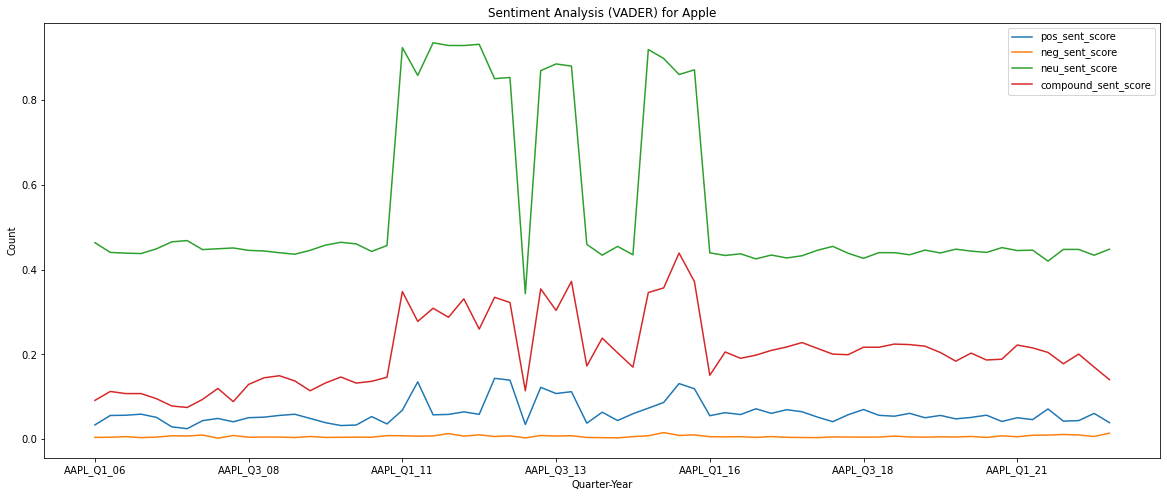

In [822]:
# For Apple -
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

apple_data['pos_sent_score'] = apple_data['Transcript'].apply(trans_pos_sent_cal)
apple_data['neg_sent_score'] = apple_data['Transcript'].apply(trans_neg_sent_cal)
apple_data['neu_sent_score'] = apple_data['Transcript'].apply(trans_neu_sent_cal)
apple_data['compound_sent_score'] = apple_data['Transcript'].apply(trans_comp_sent_cal)

apple_data.sort_values(by = ['Year', 'Quarter'], axis=0, ascending=[True, True], inplace=True,
               kind='quicksort', na_position='first', ignore_index=True, key=None)

apple_data.plot(x="FileName", y=["pos_sent_score", "neg_sent_score", "neu_sent_score", "compound_sent_score"], kind="line", figsize=(20, 8),
               xlabel="Quarter-Year",ylabel="Count", title = "Sentiment Analysis (VADER) for Apple")
plt.savefig('APPLE_vader_op.png')

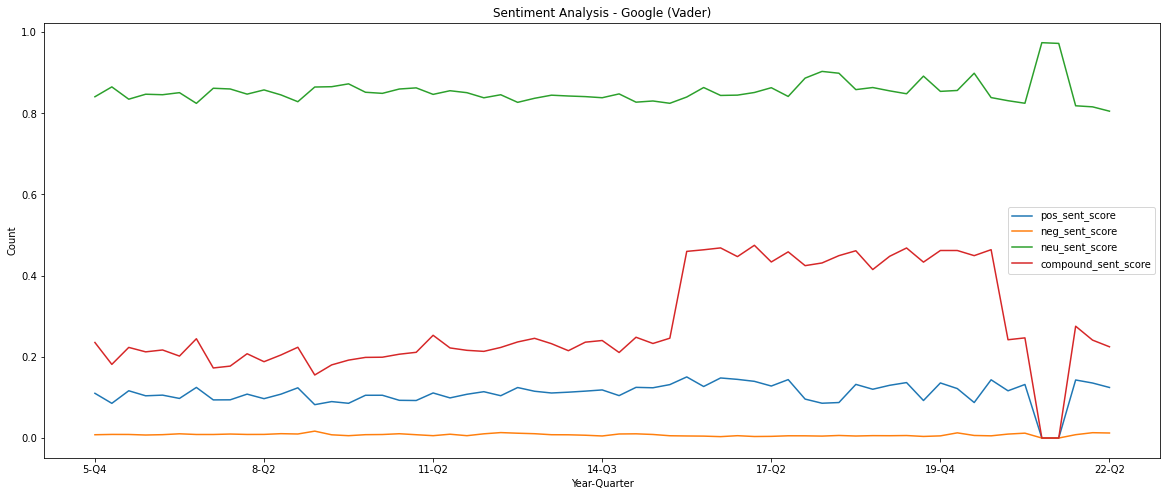

In [836]:
# For Google -

google_data['pos_sent_score'] = google_data['Transcript'].apply(trans_pos_sent_cal)
google_data['neg_sent_score'] = google_data['Transcript'].apply(trans_neg_sent_cal)
google_data['neu_sent_score'] = google_data['Transcript'].apply(trans_neu_sent_cal)
google_data['compound_sent_score'] = google_data['Transcript'].apply(trans_comp_sent_cal)

google_data.sort_values(by = ['Year', 'Quarter'], axis=0, ascending=[True, True], inplace=True,
               kind='quicksort', na_position='first', ignore_index=True, key=None)


google_data.plot(x="year_quarter", y=["pos_sent_score", "neg_sent_score", "neu_sent_score", "compound_sent_score"], kind="line", figsize=(20, 8),
                xlabel="Year-Quarter",ylabel="Count", title = "Sentiment Analysis (VADER) for Google")

plt.title('Sentiment Analysis - Google (Vader)')
plt.savefig('GOOG_vader_op.jpeg')

In [837]:
google_data

,Unnamed: 0,Transcript,Quarter,Year,preprocessed,preprocessed_sent,pos_sent_score,neg_sent_score,neu_sent_score,compound_sent_score,pos_LMD_sent_freq,neg_LMD_sent_freq,unc_LMD_sent_freq,con_LMD_sent_freq,year_quarter
0,47,Transcripts\n\nTechnology\n\nGoogle Q4 2005 Ea...,Q4,5,contract really new significant major amount ...,[contract u really new significant major amoun...,0.110172,0.008114,0.840679,0.235341,518,343,95,28,5-Q4
1,0,Transcripts\n\nTechnology\n\nGoogle Inc. Q1 20...,Q1,6,philosophical issue respect branded advertisi...,[philosophical issue respect branded advertisi...,0.085472,0.008896,0.864941,0.181424,545,381,150,36,6-Q1
2,16,Transcripts\n\nTechnology\n\nGoogle Inc. Q2 20...,Q2,6,one aware solve need local engineering talent...,[one aware solve need local engineering talent...,0.116443,0.008785,0.834624,0.223245,498,406,114,23,6-Q2
3,32,Transcripts\n\nTechnology\n\nGoogle Q3 2006 Ea...,Q3,6,profitable stop thanks know give guidance bin...,"[profitable stop thanks, know give guidance bi...",0.104031,0.007434,0.846865,0.212275,476,331,108,32,6-Q3
4,48,Transcripts\n\nTechnology\n\nGoogle Q4 2006 Ea...,Q4,6,direct partnership established major content ...,[direct partnership established major content ...,0.105676,0.008301,0.845654,0.216907,522,334,119,21,6-Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,30,Thisââtranscriptââisââprovidedââ...,Q2,21,transcript provided convenience investor full...,[transcript provided convenience investor full...,0.000000,0.000000,0.973829,0.000000,413,338,69,33,21-Q2
57,46,Thisââtranscriptââisââprovidedââ...,Q3,21,opening comment key point note result lapped ...,[opening comment key point note result lapped ...,0.000000,0.000000,0.972046,0.000000,470,339,94,41,21-Q3
58,60,This transcript is provided for the convenienc...,Q4,21,transcript provided convenience investor full...,[transcript provided convenience investor full...,0.142987,0.008254,0.818415,0.275439,511,344,77,46,21-Q4
59,15,This transcript is provided for the convenienc...,Q1,22,interesting number advertiser view side menti...,[interesting number advertiser view side menti...,0.135512,0.013155,0.815793,0.241188,428,345,72,42,22-Q1


# Word Clouds

## Google - Pre-Pichai

(-0.5, 2119.5, 1279.5, -0.5)

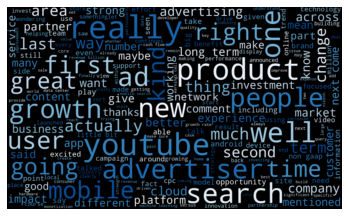

In [810]:
str_word_cloud=""
for i in google_pre_pichai['preprocessed']:
    str_word_cloud=str_word_cloud+str(i)
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color = 'black', max_font_size=200, height=1280, width = 2120,colormap="Blues_r",contour_color='skyblue', contour_width=50).generate(str_word_cloud)


import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Google - Post Pichai

(-0.5, 2119.5, 1279.5, -0.5)

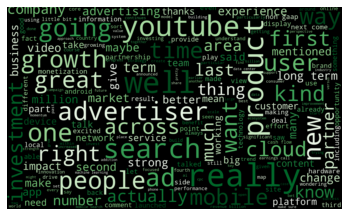

In [811]:
str_word_cloud_post_pichai=""
for i in google_post_pichai['preprocessed']:
    str_word_cloud_post_pichai=str_word_cloud_post_pichai+str(i)
    
wordcloud_post_pichai = WordCloud(background_color = 'black', max_font_size=200, height=1280, width = 2120,colormap="Greens_r",contour_color='skyblue', contour_width=50).generate(str_word_cloud_post_pichai)

plt.imshow(wordcloud_post_pichai, interpolation='bilinear')
plt.axis("off")

## Apple - Post Tim Cook (two 5 year periods)

C:\Users\Mihir\AppData\Local\Temp\ipykernel_24668\2113600097.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  apple_post_cook_first_half = apple_data[mask1][mask2]


(-0.5, 2119.5, 1279.5, -0.5)

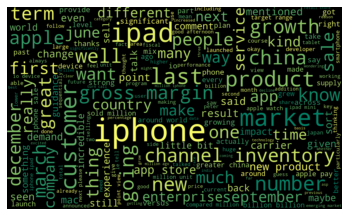

In [812]:
# Apply filters to get two 5 year periods between 2011 and 2021
mask1=apple_data['Year']>=11
mask2=apple_data['Year']<=16
apple_post_cook_first_half = apple_data[mask1][mask2]


str_word_cloud_post_cook_first_half=""
for i in apple_post_cook_first_half['preprocessed']:
    str_word_cloud_post_cook_first_half=str_word_cloud_post_cook_first_half+str(i)

wordcloud_post_cook_first_half = WordCloud(background_color = 'black', max_font_size=200, height=1280, width = 2120,colormap="summer",contour_color='skyblue', contour_width=50).generate(str_word_cloud_post_cook_first_half)

plt.imshow(wordcloud_post_cook_first_half, interpolation='bilinear')
plt.axis("off")

(-0.5, 2119.5, 1279.5, -0.5)

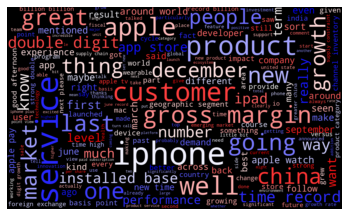

In [813]:
mask3=apple_data['Year']>=16
apple_post_cook_second_half = apple_data[mask3]
apple_post_cook_second_half

str_word_cloud_post_cook_second_half=""
for i in apple_post_cook_second_half['preprocessed']:
    str_word_cloud_post_cook_second_half=str_word_cloud_post_cook_second_half+str(i)
    
wordcloud_post_cook_second_half = WordCloud(background_color = 'black', max_font_size=200, height=1280, width = 2120,colormap="bwr",contour_color='skyblue', contour_width=50).generate(str_word_cloud_post_cook_second_half)


plt.imshow(wordcloud_post_cook_second_half, interpolation='bilinear')
plt.axis("off")

# Apple - Pre Tim Cook


(-0.5, 2119.5, 1279.5, -0.5)

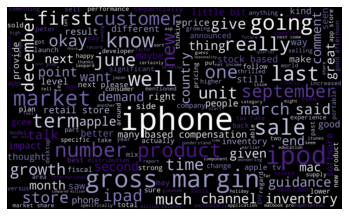

In [814]:
apple_pre_cook = apple_data[apple_data['Year']<11]
apple_pre_cook

str_word_cloud_pre_cook=""
for i in apple_pre_cook['preprocessed']:
    str_word_cloud_pre_cook=str_word_cloud_pre_cook+str(i)
    
wordcloud_pre_cook = WordCloud(background_color = 'black', max_font_size=200, height=1280, width = 2120,colormap="Purples_r",contour_color='skyblue', contour_width=50).generate(str_word_cloud_pre_cook)


plt.imshow(wordcloud_pre_cook, interpolation='bilinear')
plt.axis("off")